# BDC - Satria Data 2021

Task : Test Model

## Authors

1. Muhammad Amanda
2. Naufal Zhafran A.
3. Wahyu Setianto

## Running On

| Environtment | Keterangan | Link |
| ------------ | ---------- | ---- |
| Colab        | **Secondary**  menggunakan GPU NVIDIA TESLA K80's | [![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hyuto/bdc-2021/blob/master/notebook/Test%20Model.ipynb) |

## First Thing First

Menginstall library yang diperlukan dan mengimport library - library yang akan digunakan serta menseting variable config yang akan digunakan di dalam notebook ini.

1. Menginstal library `MTCNN` dan `Albumentations`
   
   Library `MTCNN` dan `Albumentations` adalah library yang digunakan untuk preprocessing data gambar pada notebook ini

In [1]:
!pip -q install mtcnn --upgrade
!pip -q install albumentations --upgrade

     |████████████████████████████████| 2.3 MB 4.1 MB/s 
     |████████████████████████████████| 102 kB 5.0 MB/s 
     |████████████████████████████████| 47.6 MB 39 kB/s 


2. Importing library
   
   Mengimport library yang akan digunakan dalam notebook ini.

In [2]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("Tensorflow :", tf.__version__)

Tensorflow : 2.7.0


3. Setup `CONFIG`
   
   Mensetup varible - variable yang digunakan sebagai config pada notebook ini

In [3]:
# Global var
SIZE = (200, 200)
FACE_THRESHOLD = 0.95
FACE_DETECTOR = MTCNN()

## Model

Menyiapkan model yang akan ditest.

1. Mendownload `weight` model dari 
   
   [![Github](https://img.shields.io/badge/Github-repository-black?logo=github)](https://github.com/Hyuto/bdc-2021)

In [4]:
!wget -q https://raw.githubusercontent.com/Hyuto/bdc-2021/master/models/%5BAGE%5D%20Best%20Models.zip
!wget -q https://raw.githubusercontent.com/Hyuto/bdc-2021/master/models/%5BGENDER%5D%20Best%20Models.zip
!unzip '[AGE] Best Models.zip' -d AGE
!unzip '[GENDER] Best Models.zip' -d GENDER

Archive:  [AGE] Best Models.zip
  inflating: AGE/1_best_model.h5     
  inflating: AGE/2_best_model.h5     
  inflating: AGE/0_best_model.h5     
Archive:  [GENDER] Best Models.zip
  inflating: GENDER/2_best_model.h5  
  inflating: GENDER/4_best_model.h5  
  inflating: GENDER/0_best_model.h5  
  inflating: GENDER/1_best_model.h5  
  inflating: GENDER/3_best_model.h5  


2. Build Model & load `weight`
   
   Build model dan load `weight` model yang sudah di download

In [13]:
def gender_model(kernel_s=(3,3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,kernel_s,activation='relu',input_shape=(200,200,3),
                            kernel_regularizer=tf.keras.regularizers.l2(0.001),padding="VALID"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,kernel_s,activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,kernel_s,activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128,kernel_s,activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128,kernel_s,activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

def age_model(kernel_s=(3,3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,kernel_s,activation='relu',input_shape=(200,200,3),
                            kernel_regularizer=tf.keras.regularizers.l2(0.001),padding="VALID"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Conv2D(64,kernel_s,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Conv2D(64,kernel_s,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Conv2D(128,kernel_s,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Conv2D(128,kernel_s,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Conv2D(256,kernel_s,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
        tf.keras.layers.Dense(1, activation='linear'),
    ])
    model.compile(loss="mse", optimizer="adamax", metrics=['mse'])
    return model

def model_predict(models, img):
    prediksi = np.zeros((1, 1), dtype=np.float32)
    for model in models:
      prediksi += model.predict(img)
    return prediksi.flatten() / len(models)

GENDER, AGE = [], []
for path in os.listdir('GENDER'):
    temp = gender_model()
    temp.load_weights(os.path.join('GENDER', path))
    GENDER.append(temp)
    del temp
for path in os.listdir('AGE'):
    temp = age_model()
    temp.load_weights(os.path.join('AGE', path))
    AGE.append(temp)
    del temp

## Test Model

Melakukan testing terhadap model - model yang sudah di latih dengan data gambar secara langsung.

In [59]:
""" Main code """

def get_faces(path):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    faces = FACE_DETECTOR.detect_faces(image)
    return faces

def preprocess_predict(path, face, size = SIZE):
    image = img_to_array(load_img(path))
    x, y, w, h = face
    image = image[y:y+h, x:x+w]
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32) / 255.0

    gender = model_predict(GENDER, image)
    age = model_predict(AGE, image)
    return gender[0], age[0]

def main(path):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    faces = [x['box'] for x in get_faces(path) if x['confidence'] > FACE_THRESHOLD]
    if len(faces) > 0:
      for face in faces:
        gender, age = preprocess_predict(path, face)
        gender = "Laki - laki" if gender > 0.5 else "Perempuan"
        age = int(round(age))

        x, y, w, h = face
        cv2.rectangle(image, (x, y), (x+w, y+h), (40, 215, 52), 4)
        cv2.putText(image, f'Gender : {gender}', (x, y-40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(image, f'Age : {age}', (x, y-15), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    else:
      print("Tidak ada wajah yang terdeteksi.")

    plt.figure(figsize=(14,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Accessing webcam from google colab.

In [42]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### 1. `Webcam`

Test model dengan gambar yang langsung diambil dari `webcam`.

<IPython.core.display.Javascript object>

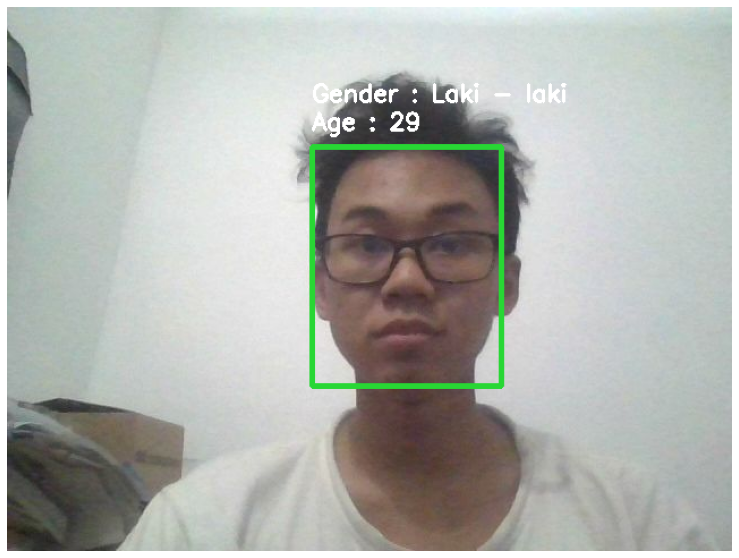

In [60]:
filename = take_photo()
main(filename)

### 2. `URL`

Test model dengan gambar yang ada di internet dengan memasukkan url.

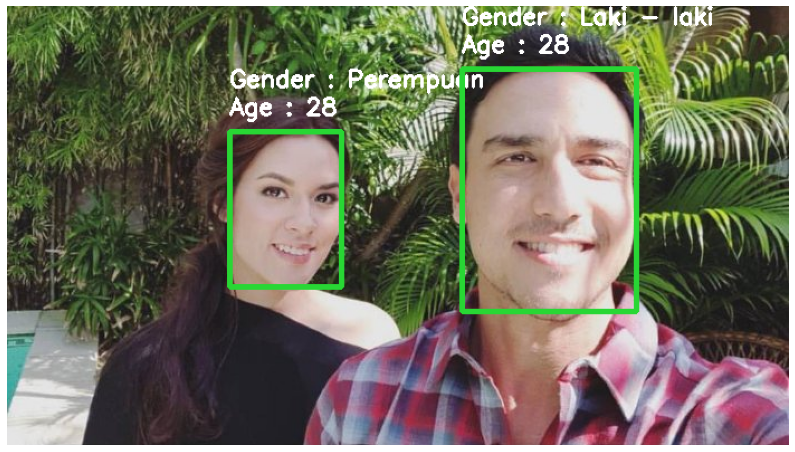

In [63]:
url = 'https://cdn-2.tstatic.net/tribunnews/foto/bank/images/raisa-dan-hamish-daud_20171207_183724.jpg'
!rm image.jpg
!wget -q {url} -O image.jpg
main('image.jpg')